In [2]:
# https://www.section.io/engineering-education/multi-person-pose-estimator-with-python/
# https://tfhub.dev/google/movenet/multipose/lightning/1

In [3]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-hub opencv-python matplotlib

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [22]:
# Load the input image.
image_path = 'test.jpeg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)

# Detection section
results = movenet(image)
keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

The output is a float32 tensor of shape [1, 6, 56]. 1 represents the batch dimension, 6 represents the maximum number of people the model can detect, and 56 represents the predicted bounding box/keypoint locations and scores.

The first 51 elements (17*3) are the keypoint locations and scores. The last five elements represent the region of the bounding box and the confidence score of the instance.

The order of the 17 keypoint joints is: [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle].

In [23]:
keypoints_with_scores

array([[[1.6328135e-01, 5.3871900e-01, 7.6127207e-01],
        [1.4653233e-01, 5.4915184e-01, 7.2433299e-01],
        [1.4463961e-01, 5.1902395e-01, 6.2670559e-01],
        [1.5345050e-01, 5.4711682e-01, 6.6055244e-01],
        [1.5176123e-01, 4.7954458e-01, 8.1911558e-01],
        [2.5465235e-01, 5.5577189e-01, 8.8816577e-01],
        [2.1000099e-01, 4.2727381e-01, 8.2278877e-01],
        [3.9287046e-01, 5.9034461e-01, 7.7492654e-01],
        [3.4531572e-01, 3.2446760e-01, 6.4468282e-01],
        [4.6772355e-01, 6.9049388e-01, 7.3136359e-01],
        [4.5713779e-01, 3.9899245e-01, 9.5277947e-01],
        [4.6643719e-01, 5.0359935e-01, 8.8140911e-01],
        [4.5831153e-01, 3.9611006e-01, 7.1756625e-01],
        [6.4701879e-01, 6.2330371e-01, 7.2715765e-01],
        [6.8915236e-01, 4.8469961e-01, 4.3929338e-01],
        [8.7741059e-01, 6.9059139e-01, 3.9316493e-01],
        [8.3985895e-01, 4.1784415e-01, 2.2333135e-01]],

       [[5.2599436e-01, 1.8279777e-01, 4.6237145e-02],
        

In [24]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [41]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 2, (0,255,0), -1)

In [42]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 1)

In [43]:
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [44]:
image = cv2.imread(image_path)
loop_through_people(image, keypoints_with_scores, EDGES,0.1)

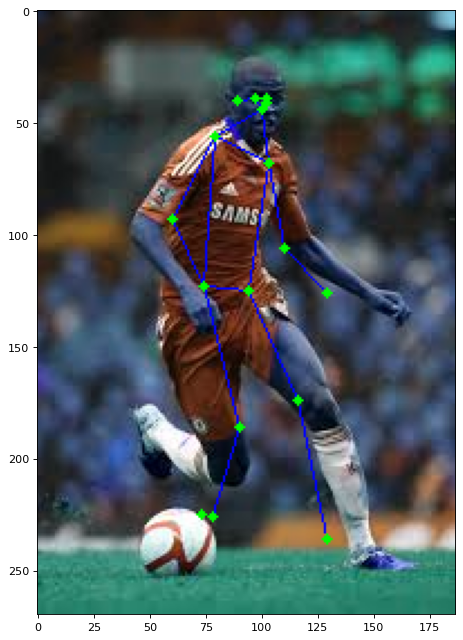

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

plt.imshow(image)
plt.show()